In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


<H1>Load Dataset

In [10]:
import glob
import os

# Load and combine all CSV files
csv_files = glob.glob("../dataset/Agriculture Crop Production/*.csv")
dataframes = []

for file in csv_files:
    try:
        temp_df = pd.read_csv(file)
        temp_df['source_file'] = os.path.basename(file)
        dataframes.append(temp_df)
        print(f"Loaded {file}: {temp_df.shape}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Use the main dataset with yield information
df = pd.read_csv("../dataset/Agriculture Crop Production/datafile (1).csv")
print("\nUsing main dataset with yield data:")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Loaded ../dataset/Agriculture Crop Production/datafile (1).csv: (49, 7)
Loaded ../dataset/Agriculture Crop Production/datafile.csv: (13, 10)
Loaded ../dataset/Agriculture Crop Production/datafile (2).csv: (55, 17)
Loaded ../dataset/Agriculture Crop Production/produce.csv: (429, 26)
Loaded ../dataset/Agriculture Crop Production/datafile (3).csv: (78, 6)

Using main dataset with yield data:
Dataset shape: (49, 6)
Columns: ['Crop', 'State', 'Cost of Cultivation (`/Hectare) A2+FL', 'Cost of Cultivation (`/Hectare) C2', 'Cost of Production (`/Quintal) C2', 'Yield (Quintal/ Hectare) ']


,Crop,State,Cost of Cultivation (`/Hectare) A2+FL,Cost of Cultivation (`/Hectare) C2,Cost of Production (`/Quintal) C2,Yield (Quintal/ Hectare)
0,ARHAR,Uttar Pradesh,9794.05,23076.74,1941.55,9.83
1,ARHAR,Karnataka,10593.15,16528.68,2172.46,7.47
2,ARHAR,Gujarat,13468.82,19551.90,1898.30,9.59
3,ARHAR,Andhra Pradesh,17051.66,24171.65,3670.54,6.42
4,ARHAR,Maharashtra,17130.55,25270.26,2775.80,8.72


# Clean Data

In [11]:
# Basic statistics
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

# Check unique values in categorical columns
print(f"\nUnique Crops: {df['Crop'].nunique()}")
print(f"Unique States: {df['State'].nunique()}")
print("\nCrops:", df['Crop'].unique()[:10])  # Show first 10
print("\nStates:", df['State'].unique()[:10])  # Show first 10

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Crop                                   49 non-null     object 
 1   State                                  49 non-null     object 
 2   Cost of Cultivation (`/Hectare) A2+FL  49 non-null     float64
 3   Cost of Cultivation (`/Hectare) C2     49 non-null     float64
 4   Cost of Production (`/Quintal) C2      49 non-null     float64
 5   Yield (Quintal/ Hectare)               49 non-null     float64
dtypes: float64(4), object(2)
memory usage: 2.4+ KB
None

Basic Statistics:
       Cost of Cultivation (`/Hectare) A2+FL  \
count                              49.000000   
mean                            20363.537347   
std                             13561.435306   
min                              5483.540000   
25%                     

In [12]:
# Clean column names and fix the yield column issue
df.columns = df.columns.str.strip().str.replace('`', '')
print("Cleaned columns:", df.columns.tolist())

# Rename the yield column properly
yield_col = [col for col in df.columns if 'Yield' in col][0]
df = df.rename(columns={yield_col: 'Yield'})
print("Renamed yield column to 'Yield'")

# Remove rows with missing values
df = df.dropna()

# Convert numeric columns
numeric_cols = ['Cost of Cultivation (/Hectare) A2+FL', 'Cost of Cultivation (/Hectare) C2', 
                'Cost of Production (/Quintal) C2', 'Yield']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()
print(f"Data shape after cleaning: {df.shape}")
df.head()

Cleaned columns: ['Crop', 'State', 'Cost of Cultivation (/Hectare) A2+FL', 'Cost of Cultivation (/Hectare) C2', 'Cost of Production (/Quintal) C2', 'Yield (Quintal/ Hectare)']
Renamed yield column to 'Yield'
Data shape after cleaning: (49, 6)


,Crop,State,Cost of Cultivation (/Hectare) A2+FL,Cost of Cultivation (/Hectare) C2,Cost of Production (/Quintal) C2,Yield
0,ARHAR,Uttar Pradesh,9794.05,23076.74,1941.55,9.83
1,ARHAR,Karnataka,10593.15,16528.68,2172.46,7.47
2,ARHAR,Gujarat,13468.82,19551.90,1898.30,9.59
3,ARHAR,Andhra Pradesh,17051.66,24171.65,3670.54,6.42
4,ARHAR,Maharashtra,17130.55,25270.26,2775.80,8.72


Select Important Columns 

In [13]:
# Select relevant columns for prediction
df = df[['Crop', 'State', 'Cost of Cultivation (/Hectare) A2+FL', 
         'Cost of Cultivation (/Hectare) C2', 'Cost of Production (/Quintal) C2', 'Yield']]
print("Selected columns:", df.columns.tolist())
df.head()

Selected columns: ['Crop', 'State', 'Cost of Cultivation (/Hectare) A2+FL', 'Cost of Cultivation (/Hectare) C2', 'Cost of Production (/Quintal) C2', 'Yield']


,Crop,State,Cost of Cultivation (/Hectare) A2+FL,Cost of Cultivation (/Hectare) C2,Cost of Production (/Quintal) C2,Yield
0,ARHAR,Uttar Pradesh,9794.05,23076.74,1941.55,9.83
1,ARHAR,Karnataka,10593.15,16528.68,2172.46,7.47
2,ARHAR,Gujarat,13468.82,19551.90,1898.30,9.59
3,ARHAR,Andhra Pradesh,17051.66,24171.65,3670.54,6.42
4,ARHAR,Maharashtra,17130.55,25270.26,2775.80,8.72


Encode Categorical Columns

In [14]:
# Encode categorical columns
label_encoders = {}
for col in ['Crop', 'State']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("Encoded categorical variables")
df.head()

Encoded categorical variables


,Crop,State,Cost of Cultivation (/Hectare) A2+FL,Cost of Cultivation (/Hectare) C2,Cost of Production (/Quintal) C2,Yield
0,0,11,9794.05,23076.74,1941.55,9.83
1,0,4,10593.15,16528.68,2172.46,7.47
2,0,2,13468.82,19551.90,1898.30,9.59
3,0,0,17051.66,24171.65,3670.54,6.42
4,0,6,17130.55,25270.26,2775.80,8.72


Train-Test Split

In [15]:
# Prepare features and target
X = df[['Crop', 'State', 'Cost of Cultivation (/Hectare) A2+FL', 
        'Cost of Cultivation (/Hectare) C2', 'Cost of Production (/Quintal) C2']]
y = df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (39, 5), Test set: (10, 5)


Train Model


In [16]:
# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model trained successfully")

Model trained successfully


Evaluate Model

In [17]:
# Make predictions and evaluate
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance
feature_names = ['Crop', 'State', 'Cost A2+FL', 'Cost C2', 'Production Cost']
importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importance)

RMSE: 71.2320
R² Score: 0.9438

Feature Importance:
           feature  importance
4  Production Cost    0.703426
2       Cost A2+FL    0.133309
3          Cost C2    0.122378
0             Crop    0.027474
1            State    0.013412


In [18]:
# Create models directory if it doesn't exist
import os
os.makedirs('../models', exist_ok=True)

# Save model and encoders
joblib.dump(model, '../models/yield_model.pkl')
joblib.dump(label_encoders, '../models/label_encoders.pkl')
print("Model and encoders saved successfully")

Model and encoders saved successfully


Plot Prediction vs Actual


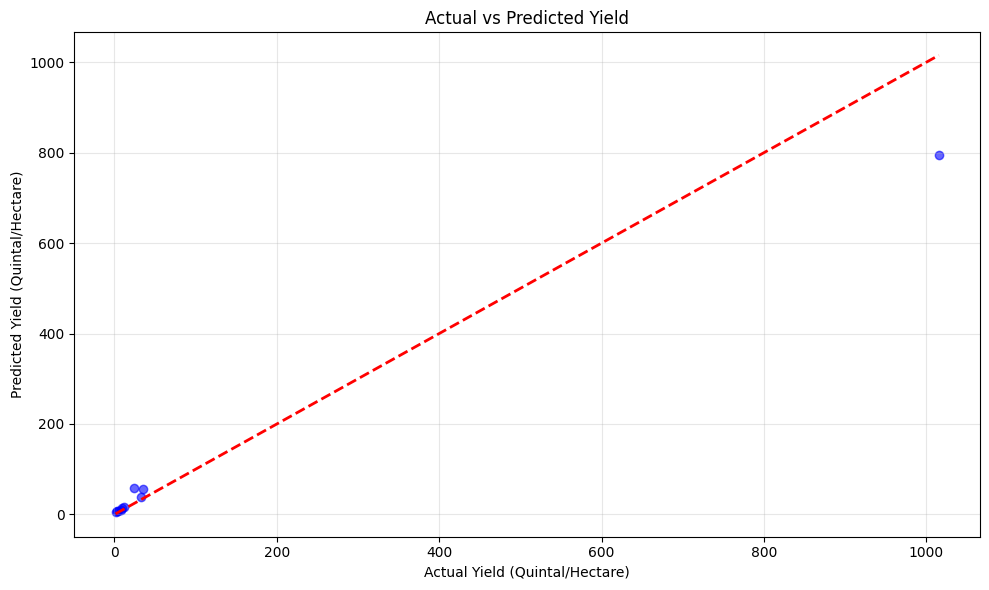

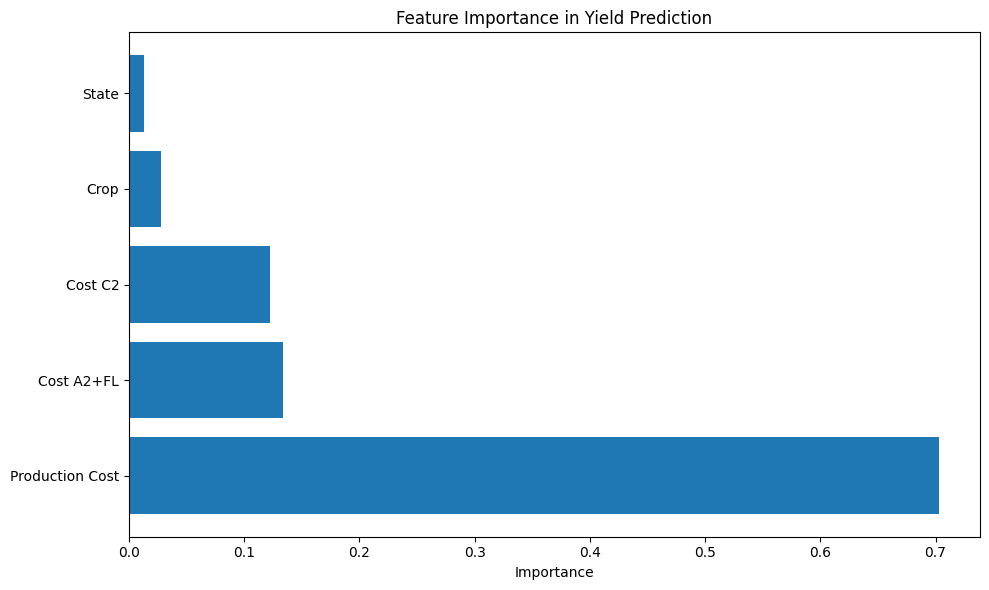

In [19]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Yield (Quintal/Hectare)')
plt.ylabel('Predicted Yield (Quintal/Hectare)')
plt.title('Actual vs Predicted Yield')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Yield Prediction')
plt.tight_layout()
plt.show()